# Distributions Comparison Techniques

This notebook tests few of the common algorithms to compare two distributions.

In [98]:
%reload_ext autoreload
%autoreload 2
import threadpoolctl

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import kl_div, rel_entr
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance, energy_distance, entropy, kstest
from intellect.distance import distributions_to_probabilities
from intellect.inspect import set_seed

threadpoolctl.threadpool_limits(limits=2);
mpl.rcParams['figure.dpi']= 70

In [89]:
%%html
<style>
table {float:left}
</style>

Generate data using the same distribution but with different parameters. Then, normalize data within 0 and 1. The two vectors simulates the same feature but from two different traffic categories.

In [125]:
set_seed()
a = np.random.poisson(10, 10000) # array of features coming from attack category A
b = np.random.poisson(3, 10000) # array of features coming from attack category B

maxx = max(a.max(), b.max())
minn = min(a.min(), b.min())

a_norm = (a - minn) / (maxx - minn) # normalize data
b_norm = (b - minn) / (maxx - minn) # normalize data

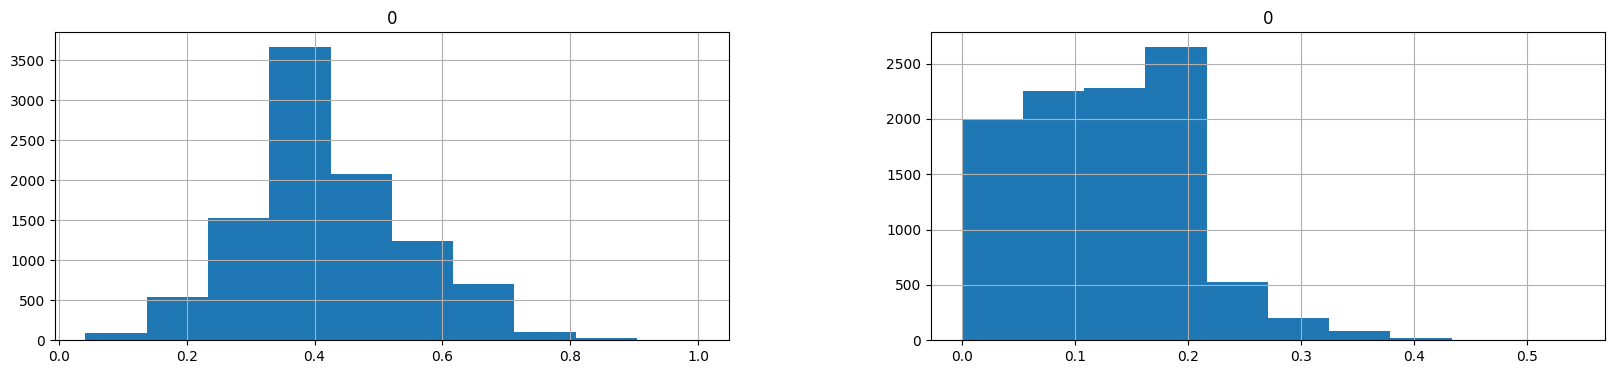

In [126]:
fig, axs = plt.subplots(1,2, figsize=(20,4))
pd.DataFrame(a_norm).hist(ax=axs[0]);
pd.DataFrame(b_norm).hist(ax=axs[1]);

As displayed in the above histograms, the two vectors are different, despite being generated using the same distribution.
Now, compute the probability distributions of the two vectors to be used as input for the following metrics.

In [129]:
_, pa_common, pb_common = distributions_to_probabilities(a_norm, b_norm, only_common=True)
_, pa_all, pb_all = distributions_to_probabilities(a_norm, b_norm, only_common=False)
pa_common.shape, pb_common.shape, pa_all.shape, pb_all.shape

((12,), (12,), (25,), (25,))

The following methods are used to check whether two vector belong to same distribution. Please note that being generated from the same distribution does not mean that the two vectors are equal/similar. Finally, in bold there's the input type accepted by the algorithm (whether probability distribution or empirical values).

1. **Kolmogorov-Smirnov Test**: The Kolmogorov-Smirnov (KS) Test is a non-parametric statistical test used to compare the cumulative distribution functions of two datasets. It quantifies the maximum vertical deviation between their *empirical distributions*, providing a measure of similarity or dissimilarity. A smaller p-value suggests significant differences between the distributions.
1. **Wasserstein Distance**: Wasserstein Distance, or Earth Mover's Distance, measures the minimum "work" or cost required to transform one **probability distribution** into another. It provides a metric for comparing the dissimilarity between two distributions based on the optimal transport plan. Lower values indicate greater similarity.
1. **Energy Distance**: Energy distance quantifies the dissimilarity between two **probability distributions** by comparing their characteristic functions. It assesses the overall difference in shapes, offering a global measure of distribution dissimilarity. Higher values indicate greater divergence between the distributions.

In [136]:
{"KS Test": kstest(a_norm,b_norm),
 "Wasserstein Distance shared points": wasserstein_distance(pa_common, pb_common),
 "Wasserstein Distance all points": wasserstein_distance(pa_all, pb_all),
 "Energy Distance shared points": energy_distance(pa_common, pb_common),
 "Energy Distance all points": energy_distance(pa_all, pb_all)}

{'KS Test': KstestResult(statistic=0.853, pvalue=0.0, statistic_location=0.20833333333333334, statistic_sign=-1),
 'Wasserstein Distance shared points': 0.03075537350525177,
 'Wasserstein Distance all points': 0.023391999999999996,
 'Energy Distance shared points': 0.10023307036664968,
 'Energy Distance all points': 0.08204974101116957}

As expected, all these methods were able to recognize that the two vectors are generated using the same distribution.

Now, we want to quantify the similarity between the two vectors. To do so, we leverage the following methods, which all accept the probability distribution of the two vectors as input.

1. **Kullback-Leibler divergence**: Kullback-Leibler divergence measures the information gain or loss when approximating one **probability distribution** with another. It quantifies the average difference in log-likelihoods between corresponding events, assessing the mismatch between two distributions. Higher KL divergence values indicate greater dissimilarity.
1. **Entropy**: Shannon entropy is a measure of the average amount of surprise or uncertainty associated with a **probability distribution**. It quantifies the level of information, measured in bits, needed to describe or predict the outcome of events governed by that distribution. Higher entropy indicates higher unpredictability or randomness, while lower entropy suggests more certainty or order in the distribution.
1. **Relative Entropy**: Relative entropy, often denoted as rel_entr, is a measure of the dissimilarity between two **probability distributions**. It quantifies the information gained or lost when approximating one distribution with another, emphasizing the difference in expectations for the outcomes. A lower relative entropy value indicates greater similarity between the distributions.
1. **Jensen Shannon**: Jensen-Shannon Divergence is a symmetric measure of dissimilarity between two **probability distributions**, calculated as the average Kullback-Leibler divergence between each distribution and their average. It provides a unified and balanced assessment of information discrepancy, with higher values indicating greater dissimilarity.

In [143]:
{"KL Div shared points": kl_div(pa_common,pb_common).sum(),
 "KL Div all points": kl_div(pa_all,pb_all).sum(),
 "Entropy shared points": entropy(pa_common,pb_common),
 "Entropy all points": entropy(pa_all,pb_all),
 "Relative Entropy shared points": rel_entr(pa_common,pb_common).sum(),
 "Relative Entropy all points": rel_entr(pa_all,pb_all).sum(),
 "Jensen Shannon shared points": jensenshannon(pa_common,pb_common),
 "Jensen Shannon all points": jensenshannon(pa_all,pb_all)}

{'KL Div shared points': 3.5991686077435254,
 'KL Div all points': inf,
 'Entropy shared points': 3.5991686077435263,
 'Entropy all points': inf,
 'Relative Entropy shared points': 3.599168607743526,
 'Relative Entropy all points': inf,
 'Jensen Shannon shared points': 0.692176087946503,
 'Jensen Shannon all points': 0.7147514098680565}